<a href="https://colab.research.google.com/github/chunxu8894/tensorflow-tutorials/blob/master/Text_classification_with_preprocessed_text_Movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tf_nightly
import tensorflow as tf

     |████████████████████████████████| 517.2MB 30kB/s 
     |████████████████████████████████| 2.9MB 49.4MB/s 
     |████████████████████████████████| 460kB 48.8MB/s 


In [3]:
from tensorflow import keras
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
import numpy as np

print(tf.__version__)

2.2.0-dev20200407


## 1. Download the IMDB dataset
THe IMDB movie reviews datasets have been converted to sequences of integers

In [4]:
(train_data, test_data), info = tfds.load('imdb_reviews/subwords8k', split=(tfds.Split.TRAIN, tfds.Split.TEST), as_supervised=True, with_info=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete289FIW/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete289FIW/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete289FIW/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


### Try the encoder

the dataset info includes the text encoder (a __tfds.features.text.SubwordTextEncoder__).

In [6]:
encoder = info.features['text'].encoder

print('Vocabulara size: %s ' % (encoder.vocab_size))

Vocabulara size: 8185 


This text encoder will reversibly encode any string:

In [9]:
sample_string = 'Hello Tensorflow'

encoded_string = encoder.encode(sample_string)
print(encoded_string)

decoded_string = encoder.decode(encoded_string)
print(decoded_string)

[4025, 222, 6307, 2327, 2934]
Hello Tensorflow


This encoder encode the string by breaking it into subword or characters if the word is not in its dictionary. So the more a string resembles the dataset, the shorter the encoded representation will be

In [11]:
for ts in encoded_string:
  print("{}  =>> {}".format(ts, encoder.decode([ts])))

4025  =>> Hell
222  =>> o 
6307  =>> Ten
2327  =>> sor
2934  =>> flow


## 2. Explorer the data
The dataset comes preprocessed: each sample is an array of integers reprenseting the word of the movie reviews. The text of reviews have been converted to integers, where each integer represents a specifi word-piece in the dictionary.
Each label is an integer value of eithre 0 or 1. where 0 is negative review and 1 is positive review

In [14]:
for train_example, train_label in train_data.take(1):
  print(type(train_example))
  print("Train example: ", train_example[:100])
  print(type(train_label))
  print('Encoded Text: ', train_example[:10].numpy())
  print("Label: ", train_label)

<class 'tensorflow.python.framework.ops.EagerTensor'>
Train example:  tf.Tensor(
[  62   18   41  604  927   65    3  644 7968   21   35 5096   36   11
   43 2948 5240  102   50  681 7862 1244    3 3266   29  122  640    2
   26   14  279  438   35   79  349  384   11 1991    3  492   79  122
  188  117   33 4047 4531   14   65 7968    8 1819 3947    3   62   27
    9   41  577 5044 2629 2552 7193 7961 3642    3   19  107 3903  225
   85  198   72    1 1512  738 2347  102 6245    8   85  308   79 6936
 7961   23 4981 8044    3 6429 7961 1141 1335 1848 4848   55 3601 4217
 8050    2], shape=(100,), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'>
Encoded Text:  [  62   18   41  604  927   65    3  644 7968   21]
Label:  tf.Tensor(0, shape=(), dtype=int64)


## 3. Preparing the data for training
You will want to create batches of traing data for your model. The reviews are all different lengths, so use __padded_batch__ to zero pad the sequences while batching

In [0]:
BUFFER_SIZE = 1000

train_batches = (train_data.shuffle(BUFFER_SIZE).padded_batch(32, padded_shapes=([None], [])))
test_batches = (test_data.padded_batch(32, padded_shapes=([None], [])))

**Note: As of TensorFlow 2.2 the padded_shapes argument is no longer required. The default behavior is to pad all axes to the longest in the batch.**

Each batch will have a shape of (batch_size, sequence_length) because the padding is dynamic each batch will have a different length

In [20]:
for example_batch,label_batch in train_batches.take(10):
  print(example_batch.shape)
  print(label_batch.shape)

(32, 1615)
(32,)
(32, 1497)
(32,)
(32, 1217)
(32,)
(32, 1432)
(32,)
(32, 934)
(32,)
(32, 1052)
(32,)
(32, 754)
(32,)
(32, 1296)
(32,)
(32, 920)
(32,)
(32, 977)
(32,)


## 4. Build the model

Always requires some main architectural decisions:
- How many layers to use in the model?
- How many hidden units to use for each layer?

In this example, the input data consist of an array of word-indices. The label to predict are eithre 0 or 1. Let's build a "Continous bag of words" style model for this problem:

*** Caution: This model doesn't use masking, so the zero-padding is used as part of the input, so the padding length may affect the output. To fix this, see the masking and padding guide. ***

In [21]:
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


1. Embedding layer takes the inter-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The result dimensions are : (batch, sequence, embedding)
2.
3.

Hidden Units



## Loss function and optimer

optimizer adam
loss function: binary_crossentropy

In [0]:
model.compile(optimizer='adam', loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

## 5. Train the model


In [24]:
history = model.fit(train_batches, epochs=20, validation_data=test_batches, validation_steps=30)

Epoch 1/20
782/782 [==============================] - 6s 8ms/step - loss: 0.6819 - accuracy: 0.5008 - val_loss: 0.6632 - val_accuracy: 0.5052
Epoch 2/20
782/782 [==============================] - 6s 8ms/step - loss: 0.6175 - accuracy: 0.5577 - val_loss: 0.5930 - val_accuracy: 0.6250
Epoch 3/20
782/782 [==============================] - 6s 8ms/step - loss: 0.5371 - accuracy: 0.6700 - val_loss: 0.5301 - val_accuracy: 0.6583
Epoch 4/20
782/782 [==============================] - 6s 8ms/step - loss: 0.4702 - accuracy: 0.7578 - val_loss: 0.4794 - val_accuracy: 0.7552
Epoch 5/20
782/782 [==============================] - 6s 8ms/step - loss: 0.4201 - accuracy: 0.8028 - val_loss: 0.4432 - val_accuracy: 0.8188
Epoch 6/20
782/782 [==============================] - 7s 8ms/step - loss: 0.3790 - accuracy: 0.8344 - val_loss: 0.4159 - val_accuracy: 0.8010
Epoch 7/20
782/782 [==============================] - 7s 9ms/step - loss: 0.3466 - accuracy: 0.8550 - val_loss: 0.3974 - val_accuracy: 0.8146
Epoch 

## 6. Evaluate the model

In [25]:
model.evaluate(test_batches, verbose=1)

782/782 [==============================] - 3s 4ms/step - loss: 0.3124 - accuracy: 0.8656


[0.3123665452003479, 0.8656399846076965]

## 7. Create a graph of accuracy and loss over time
model.fit() returns a  History object that contains a dictionary with everything that happened during training:

In [37]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [39]:
print(history_dict)
print(type(history_dict['loss']))
print(len(history_dict['loss']))

{'loss': [0.6819460988044739, 0.6174927353858948, 0.5370632410049438, 0.47018495202064514, 0.4200734496116638, 0.37898528575897217, 0.3465857207775116, 0.3217228353023529, 0.30136343836784363, 0.28381335735321045, 0.27082887291908264, 0.26030948758125305, 0.2478310614824295, 0.2364913523197174, 0.2281242460012436, 0.21891595423221588, 0.2115582376718521, 0.20481328666210175, 0.19809368252754211, 0.19211573898792267], 'accuracy': [0.5008400082588196, 0.5576800107955933, 0.6700400114059448, 0.7577999830245972, 0.802839994430542, 0.8343600034713745, 0.8550400137901306, 0.868120014667511, 0.8792799711227417, 0.8866000175476074, 0.8943600058555603, 0.9009199738502502, 0.9036800265312195, 0.9093599915504456, 0.9125999808311462, 0.9157999753952026, 0.9202399849891663, 0.9222400188446045, 0.9241200089454651, 0.9269999861717224], 'val_loss': [0.6632464528083801, 0.5930337309837341, 0.5300734043121338, 0.47943368554115295, 0.4432477056980133, 0.4158811569213867, 0.3973638117313385, 0.38057726621

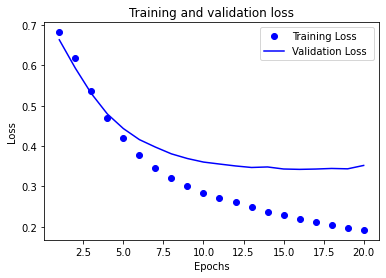

In [41]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
loss = history_dict['loss']
val_acc = history_dict['val_accuracy']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

# 'bo' is for 'blue dot'
# 'b' is for ' solid blue line'
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss ')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

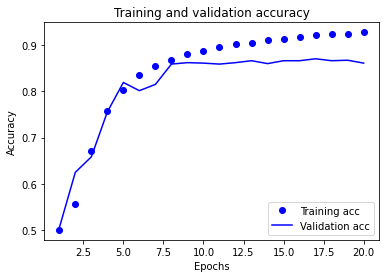

In [42]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()


This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test dat

Source: https://www.tensorflow.org/tutorials/keras/text_classification